<a href="https://colab.research.google.com/github/yleessam/tf/blob/main/yolo/object_detecting_yolov3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 정지 영상에서 객체 탐지

## 필요한 라이브러리 import

In [1]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow # Google Colab에서 이미지를 표시하기 위한 함수

## YOLO(YOu Only Look Once) 모델 관련 파일 다운로드

In [2]:
# YOLO(YOu Only Look Once) 모델의 구성, 가중치 파일, 그리고 클래스 이름을 다운로드
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O yolov3.cfg
!wget https://github.com/pjreddie/darknet/blob/master/data/coco.names?raw=true -O coco.names

--2024-02-05 14:14:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  11.8MB/s    in 29s     

2024-02-05 14:15:11 (8.11 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2024-02-05 14:15:11--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2024-02-05 14:15:11--  https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg
Reusing existing connection to github.com:443.
HTTP request sent, awaiti

## YOLO 모델 초기화 및 로드 함수

In [3]:
def load_yolo():
    # YOLO 네트워크를 초기화하고 가중치 및 설정 파일을 불러옵니다.
    net = cv.dnn.readNet("yolov3.weights", "yolov3.cfg")
    # COCO 데이터셋의 클래스 이름을 불러와 리스트로 저장합니다.
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]
    # 네트워크에서 사용하는 레이어의 이름을 가져옵니다.
    layers_names = net.getLayerNames()
    # 출력 레이어를 결정합니다. YOLO 네트워크의 출력 레이어는 탐지 결과를 포함합니다.
    output_layers = [layers_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    # 탐지된 객체에 할당할 색상을 무작위로 생성합니다.
    colors = np.random.uniform(0, 255, size=(len(classes), 3))
    return net, classes, colors, output_layers

## 이미지 로드 및 전처리 함수

In [4]:
# 이미지를 불러오고, YOLO 입력 크기로 크기를 조정합니다.
def load_image(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    return img, height, width, channels

## 객체 탐지 함수

In [5]:
def detect_objects(img, net, outputLayers):
    # 이미지로부터 blob을 생성합니다. Blob은 입력으로 사용
    blob = cv.dnn.blobFromImage(img, scalefactor=0.00392, size=(416, 416), mean=(0, 0, 0), swapRB=True, crop=False)
    # 신경망에 입력으로 설정
    net.setInput(blob)
    # 전방 전달 실행 및 출력 얻기
    outputs = net.forward(outputLayers)
    return blob, outputs


## 탐지된 객체 정보


YOLO 네트워크의 출력에서 객체의 위치와 해당 클래스의 신뢰도를 추출하여 리스트로 저장

YOLO 모델의 출력을 파싱하여 각 객체에 대한 경계 상자의 위치, 신뢰도 점수 및 클래스 ID를 추출합니다. 이 정보는 객체를 이미지 위에 표시하거나 추가 분석을 위해 사용

In [6]:
def get_box_dimensions(outputs, height, width):
    # 경계 상자, 신뢰도 점수 및 클래스 ID를 저장할 리스트를 초기화합니다.
    boxes = []     # 각 객체의 경계 상자 좌표를 저장할 리스트
    confs = []     # 각 객체 탐지의 신뢰도 점수를 저장할 리스트
    class_ids = [] # 탐지된 각 객체의 클래스 ID를 저장할 리스트

    # 네트워크의 출력을 반복하여 각 탐지된 객체에 대한 정보를 추출합니다.
    for output in outputs:
        for detect in output:
            # 클래스 예측 점수를 추출합니다 (첫 5개 요소는 박스 좌표와 객체 신뢰도 점수이므로 제외).
            scores = detect[5:]
            # 가장 높은 점수를 가진 클래스 ID를 찾습니다.
            class_id = np.argmax(scores)
            # 해당 클래스 ID의 신뢰도 점수를 얻습니다.
            confidence = scores[class_id]

            # 신뢰도 점수가 0.5보다 큰 경우만 객체로 간주합니다.
            if confidence > 0.5:
                # 경계 상자의 중심 좌표와 크기를 추출합니다.
                center_x = int(detect[0] * width)
                center_y = int(detect[1] * height)
                w = int(detect[2] * width)
                h = int(detect[3] * height)

                # 경계 상자의 좌표를 추출합니다 (상자의 중심에서 상자의 모서리로 변환).
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                # 경계 상자의 좌표, 신뢰도 점수, 클래스 ID를 각각의 리스트에 추가합니다.
                boxes.append([x, y, w, h])
                confs.append(float(confidence))
                class_ids.append(class_id)

    # 추출된 경계 상자의 좌표, 신뢰도 점수 및 클래스 ID 리스트를 반환합니다.
    return boxes, confs, class_ids


## NMS & 바운딩 박스 그리기 함수

In [7]:
def draw_labels(boxes, confs, colors, class_ids, classes, img):
    indexes = cv.dnn.NMSBoxes(boxes, confs, 0.5, 0.4)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confs[i]
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, f"{label} {confidence:.2f}", (x, y + 30), font, 1, color, 2)
    cv2_imshow(img)

## 객체 탐지 실행


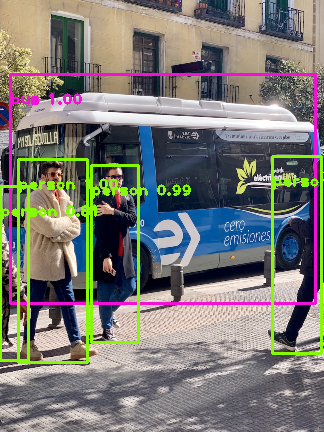

In [8]:
# YOLO 모델을 초기화하고 필요한 구성 요소를 로드합니다.
net, classes, colors, output_layers = load_yolo()

# 이미지를 로드하고, 그 이미지의 높이, 너비 및 채널 정보를 가져옵니다.
#image, height, width, channels = load_image("street2.jpg")
image, height, width, channels = load_image("bus.jpg")

# 이미지에서 객체를 탐지합니다. 이미지를 blob으로 변환하고,
# YOLO 네트워크를 통해 전방 전달을 수행하여 객체 탐지 결과를 얻습니다.
blob, outputs = detect_objects(image, net, output_layers)

# 탐지된 객체들의 경계 상자, 신뢰도 점수, 그리고 클래스 ID를 계산합니다.
# 이 정보는 네트워크 출력에서 추출되며, 객체의 위치와 크기, 신뢰도 점수를 포함합니다.
boxes, confs, class_ids = get_box_dimensions(outputs, height, width)

# 이미지 위에 각 객체의 경계 상자와 레이블을 그립니다.
# 여기서 각 탐지된 객체에 대한 정보(경계 상자, 신뢰도, 클래스)를 시각화합니다.
draw_labels(boxes, confs, colors, class_ids, classes, image)
